# Lending Club Case Study

## Data Understanding and Cleaning

In [1]:
# Importing necessary libraries
import pandas as pd, numpy as np

import warnings
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

import matplotlib.pyplot as plt

import seaborn as snp

In [2]:
# Reading the loan.csv dataset and creating loan_master dataframe

loan_master= pd.read_csv("loan.csv", encoding='unicode_escape')
loan_master.shape

(39717, 111)

`Clearly there are many columns(111) and we can try cleaning the dataset by dropping all NULL rows and columns`

In [3]:
#removing all those null columns
loan=loan_master.dropna(axis=1,how='all')
loan.shape

(39717, 57)

```After this we are left with 57 columns```

In [4]:
#fetching all columns with null values more than 30% 
numberofnullrowsalt=loan.isnull().sum()
numberofnullrowsalt[numberofnullrowsalt.values > (0.3* len(loan))]

desc                      12940
mths_since_last_delinq    25682
mths_since_last_record    36931
next_pymnt_d              38577
dtype: int64

In [5]:
# dropping columns having more than 30% null values
loan=loan.drop(columns=['desc','mths_since_last_delinq','mths_since_last_record','next_pymnt_d'])
loan.shape
#now we are left with 53 columns

#dropping irrelavant columns that doesn't help in any of our analysis
loan=loan.drop(columns=['zip_code','id','member_id','url'])
loan.shape

(39717, 49)

In [6]:
# correcting int_rate column by removing % and converting to numeric for using it for further analysis
loan['int_rate']=loan['int_rate'].apply(lambda x: x.strip('%'))
loan['int_rate']=loan['int_rate'].apply(lambda x: float(x))
loan['int_rate']=loan['int_rate'].sort_values(ascending=True)
#print(loan['int_rate'])

# Deriving column issue_month from issue_d for further analysis
loan['issue_month'] = loan['issue_d'].apply(lambda x: x.split('-')[0])


In [7]:
# Duplicating loan dataframe to establish correlation between loan_status and other variables for further analysis
loan_corr = loan

In [8]:
# Finding default rate for which loan_status has to be cleaned first 

#dropping rows with loan_status as 'Current' as it doesn't help us decide whether a customer would default or not
loan = loan[loan['loan_status']!='Current']

# coverting loan_status to numeric - loan_status_num to make it manageable for further analysis
loan['loan_status_num'] = loan['loan_status'].astype('category').cat.codes

print('Counts of Charged off and Fully paid i.e. Defaulters and Non Defaulters respectively\n')
print(loan.loan_status.value_counts())

print('\n\nCounts of 0 and 1 i.e Charged off and Fully paid respectively' )
loan.loan_status_num.value_counts()

Counts of Charged off and Fully paid i.e. Defaulters and Non Defaulters respectively

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64


Counts of 0 and 1 i.e Charged off and Fully paid respectively


1    32950
0     5627
Name: loan_status_num, dtype: int64

`Henceforth, loan_status_num '0' represents loan-status 'Charged Off(Defaulters)' and loan_status_num '1' represents loan-status 'Fully Paid(Non Defaulters)'`

## Data Analysis

### 1. Correlation Matrix

In [9]:
# We already have a duplicate dataframe loan_corr
#dropping rows with loan_status as 'Current' as it doesn't help us decide whether a customer would default or not
loan_corr = loan_corr[loan_corr['loan_status']!='Current']

In [10]:
# finding the columns with categorical data
cols = loan_corr.columns
n_cols = loan_corr._get_numeric_data().columns
n_cols 
catlist=list(set(cols) - set(n_cols))

# converting categorical columns to numeric
for column in loan_corr:
    if column in catlist:
        loan_corr[column] = loan_corr[column].astype('category').cat.codes

In [11]:
#correlation matrix
loan_corr.corr().style.background_gradient(cmap='BrBG', axis=None).set_precision(2)

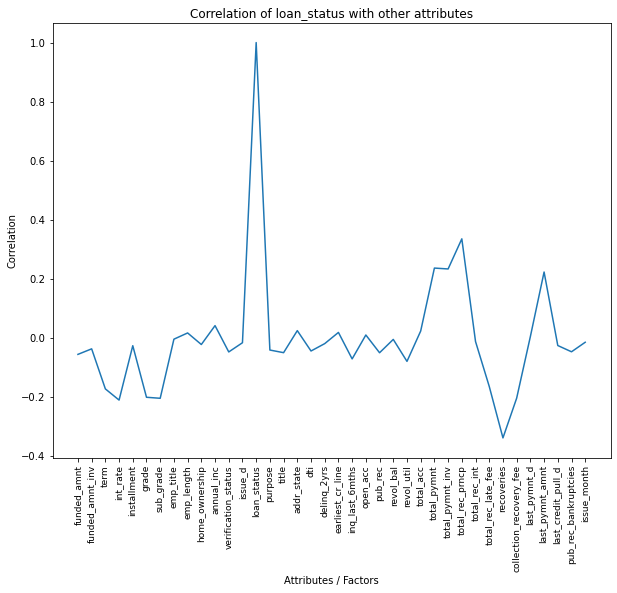

In [12]:
#fetching the Correlation of attributes with loan_status alone
loan_status_corr=loan_corr[loan_corr.columns[1:]].corr()['loan_status'][:]
loan_status_corr=loan_status_corr.dropna()
fig = plt.figure(figsize=(10,8))
plt.title('Correlation of loan_status with other attributes')
plt.xlabel('Attributes / Factors')
plt.ylabel('Correlation')
plt.xticks(rotation = 90, fontsize = 9)
plt.plot(loan_status_corr)
plt.show()
#The highest peaks(Correlation value = 1) in the correlation plot below is between loan_status itself.

In [13]:
#fetching only top 5 highly negatively correlated attributes with loan_status
loan_status_corr.sort_values(ascending=True).head(5)

recoveries                -0.339562
int_rate                  -0.211390
sub_grade                 -0.205320
collection_recovery_fee   -0.204914
grade                     -0.201869
Name: loan_status, dtype: float64

In [14]:
#fetching only top 6 highly positively correlated attributes with loan_status including loan_status
loan_status_corr.sort_values(ascending=True).tail(6)

annual_inc         0.040867
last_pymnt_amnt    0.222524
total_pymnt_inv    0.232906
total_pymnt        0.235898
total_rec_prncp    0.334944
loan_status        1.000000
Name: loan_status, dtype: float64

### **Insights:** 
`From the correlation matrix the following factors that are found to be highly correlated with loan_status`<br>
`However we are not concluding these as the top factors as few of them are customer behavioural attributes which are not available at the time of Loan application. Hence proceeding with further analysis using Default rate`<br><br>
1) recoveries<br>
2) int_rate<br>
3) sub_grade<br>
4) collection_recovery_fee<br>
5) grade <br>
6) annual_inc<br>
7) last_pymnt_amnt<br>
8) total_pymnt_inv<br>
9) total_pymnt<br>
10) total_rec_prncp<br>


## Analysis / Data Visualization

### Univariate Analysis

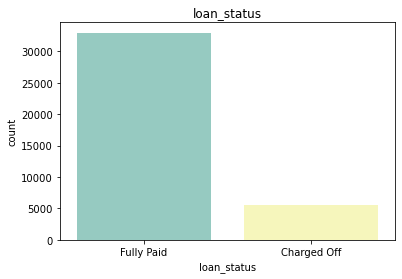

Fully Paid     32950
Charged Off     5627
Name: loan_status, dtype: int64


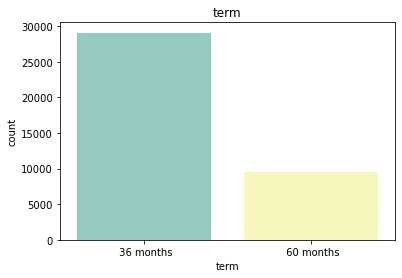

 36 months    29096
 60 months     9481
Name: term, dtype: int64


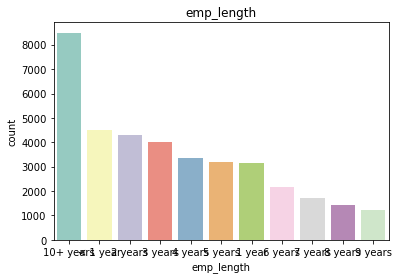

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
Name: emp_length, dtype: int64


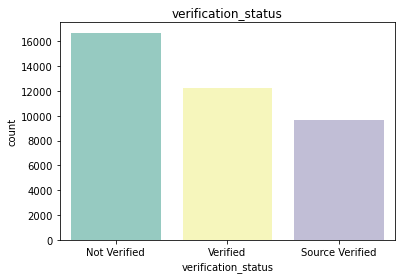

Not Verified       16694
Verified           12206
Source Verified     9677
Name: verification_status, dtype: int64


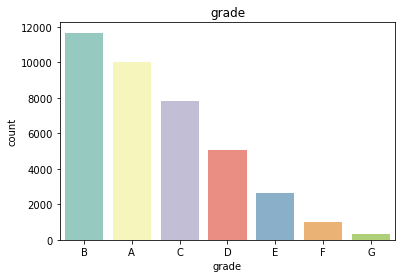

B    11675
A    10045
C     7834
D     5085
E     2663
F      976
G      299
Name: grade, dtype: int64


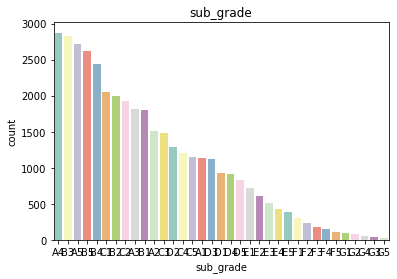

A4    2873
B3    2825
A5    2715
B5    2615
B4    2437
C1    2055
B2    2001
C2    1931
A3    1810
B1    1797
A2    1508
C3    1488
D2    1286
C4    1206
C5    1154
A1    1139
D3    1116
D1     931
D4     918
D5     834
E1     722
E2     614
E3     516
E4     424
E5     387
F1     305
F2     233
F3     174
F4     151
F5     113
G1      94
G2      77
G4      54
G3      45
G5      29
Name: sub_grade, dtype: int64


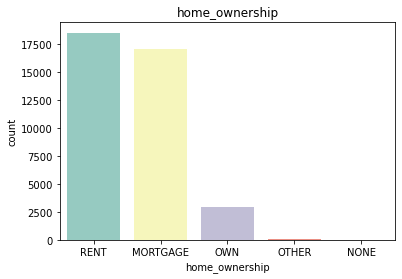

RENT        18480
MORTGAGE    17021
OWN          2975
OTHER          98
NONE            3
Name: home_ownership, dtype: int64


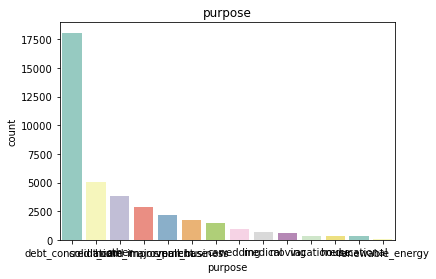

debt_consolidation    18055
credit_card            5027
other                  3865
home_improvement       2875
major_purchase         2150
small_business         1754
car                    1499
wedding                 926
medical                 681
moving                  576
vacation                375
house                   367
educational             325
renewable_energy        102
Name: purpose, dtype: int64


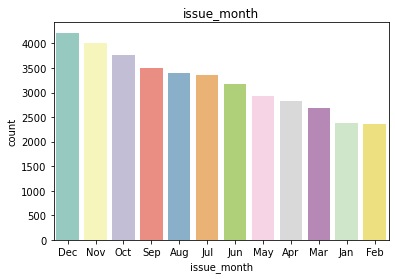

Dec    4215
Nov    4006
Oct    3761
Sep    3498
Aug    3388
Jul    3351
Jun    3180
May    2919
Apr    2831
Mar    2691
Jan    2379
Feb    2358
Name: issue_month, dtype: int64


In [15]:
# Defining a univaranl function to perform Univariate analysis on any column interested to get insights

def univaranl(df,col):
    snp.countplot(data = loan, x= col, order=loan[col].value_counts().index, palette="Set3")
    plt.xlabel(col)
    plt.title(col)
    plt.show()
    print(loan[col].value_counts())
    
# Univariate CATEGORICAL analysis
univaranl(loan,'loan_status')
univaranl(loan,'term')
univaranl(loan,'emp_length')
univaranl(loan,'verification_status')
univaranl(loan,'grade')
univaranl(loan,'sub_grade')
univaranl(loan,'home_ownership')
univaranl(loan,'purpose')
univaranl(loan,'issue_month')

# Univariate NUMERIC - delinq_2yrs analysis
#univaranl(loan,'delinq_2yrs')

In [16]:
# Defining function which can be called to plot default rate v/s other variables 
# Default rate = No of applicants Charged Off / Total No of applicants
# Returns key value pair i.e.Columnname and difference between max and min, everytime.

def plotdefaultrate(dtfrm,col):
    # crosstab to be used to get a table of possible values of the 'col' variable and possible loan_status_num values and the total so the default rate can be calculated
    ctab=pd.crosstab(loan[col],loan['loan_status_num'], margins=True)
    
    # formula used for default rate is count of defaulters i.e. No of zeroes divided by total applicants
    ctab['default_rate']=round((ctab[0]/ctab['All']),2)
    
    # finding the max and min defaut rate for the given variable category 
    colmax=ctab['default_rate'].max()
    colmin=ctab['default_rate'].min()
    
    # finding the difference - more the difference, more the influence variable has on Default rate
    coldiff=colmax - colmin
    
    dct = {col:coldiff} # variable name and the correspodning max,min difference
    
    # plotting the default rate against the variable
    ctab=ctab[0:-1]
    ax=ctab['default_rate'].plot(kind='bar',rot=90)
    ax.set_xlabel(loan[col].name.title(),fontsize=15)
    ax.set_ylabel('Default rate',color = 'g',fontsize=15)
    plt.show()
    
    return dct


### Segmented Univariate Analysis for Categorical variables

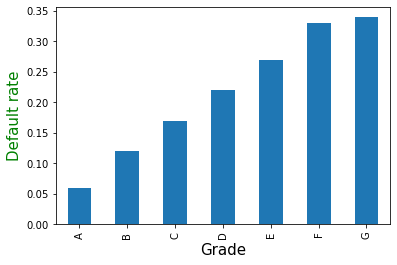

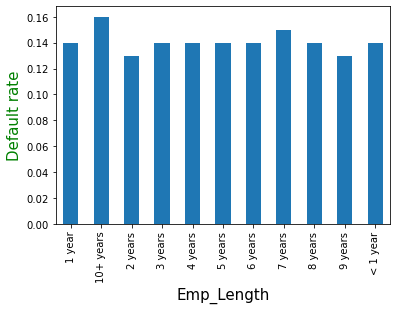

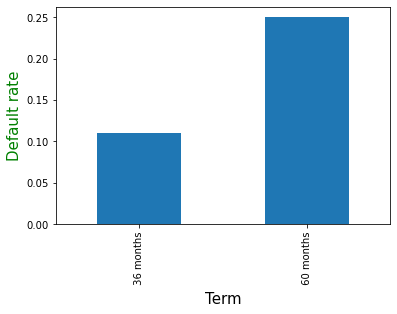

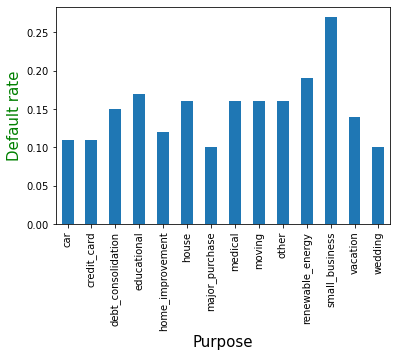

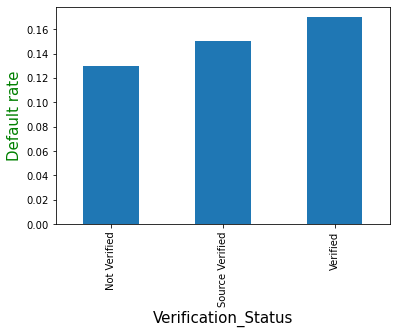

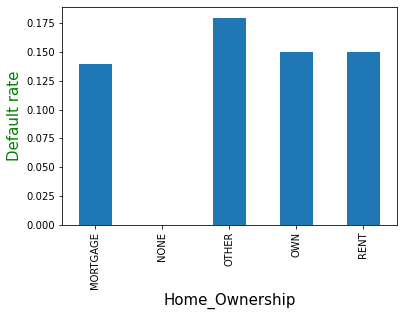

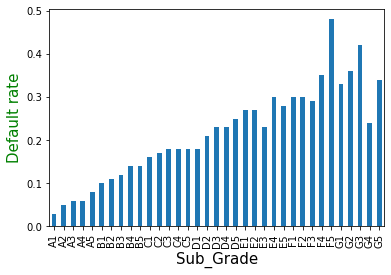

In [17]:
# new dict to hold the key value pairs returned by plotdefaultrate function
newdiff={}

# calling the plotdefaultrate function for loan attributes and customer attributes

newdiff.update(plotdefaultrate(dtfrm=loan,col='grade'))
newdiff.update(plotdefaultrate(dtfrm=loan,col='emp_length'))
newdiff.update(plotdefaultrate(dtfrm=loan,col='term'))
newdiff.update(plotdefaultrate(dtfrm=loan,col='purpose'))
newdiff.update(plotdefaultrate(dtfrm=loan,col='verification_status'))
newdiff.update(plotdefaultrate(dtfrm=loan,col='home_ownership'))
newdiff.update(plotdefaultrate(dtfrm=loan,col='sub_grade'))


### Univariate Analysis with Derived Metrics for Continuous variables using binning

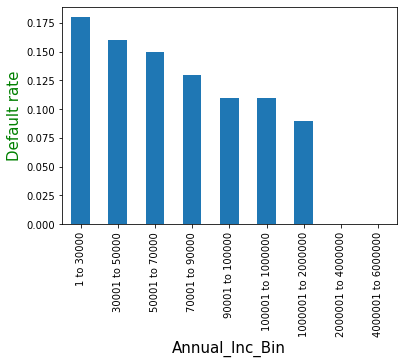

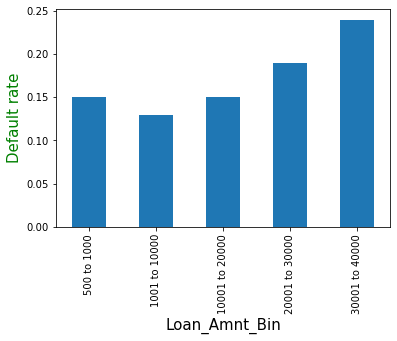

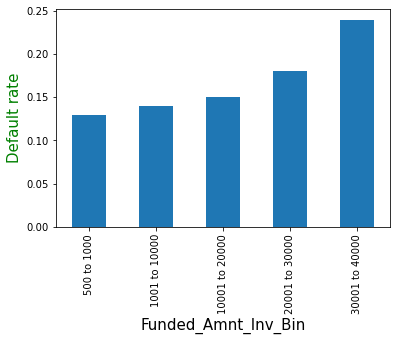

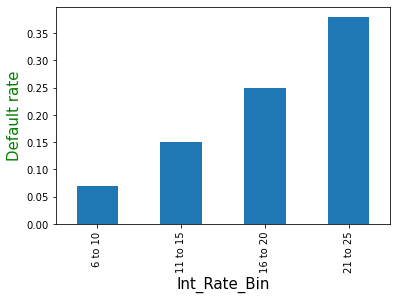

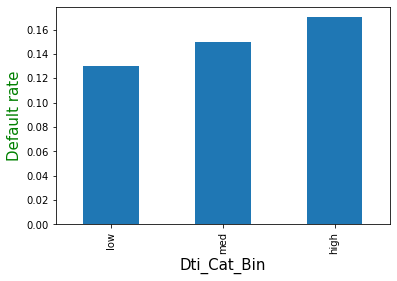

In [18]:
# Deriving metrics using Binning here for analysis of ther loan and customer attributes

loan['annual_inc_bin'] = pd.cut(x=loan['annual_inc'], bins=[10000,30000,50000,70000,90000,100000,1000000,2000000,4000000,6000000],labels=['1 to 30000','30001 to 50000','50001 to 70000','70001 to 90000','90001 to 100000','100001 to 1000000','1000001 to 2000000','2000001 to 4000000','4000001 to 6000000'])
newdiff.update(plotdefaultrate(dtfrm=loan,col='annual_inc_bin'))

loan['loan_amnt_bin'] = pd.cut(x=loan['loan_amnt'], bins=[500, 1000, 10000, 20000, 30000,40000, 50000,60000],labels=['500 to 1000','1001 to 10000','10001 to 20000','20001 to 30000','30001 to 40000','40001 to 50000','50001 to 60000'])
newdiff.update(plotdefaultrate(dtfrm=loan,col='loan_amnt_bin'))

loan['funded_amnt_inv_bin'] = pd.cut(x=loan['funded_amnt_inv'], bins=[500, 1000, 10000, 20000, 30000,40000, 50000,60000],labels=['500 to 1000','1001 to 10000','10001 to 20000','20001 to 30000','30001 to 40000','40001 to 50000','50001 to 60000'])
newdiff.update(plotdefaultrate(dtfrm=loan,col='funded_amnt_inv_bin'))

loan['int_rate_bin'] = pd.cut(x=loan['int_rate'], bins=[0,5,10,15,20,25,30],labels=['0 to 5','6 to 10','11 to 15','16 to 20','21 to 25','26 to 30'])
newdiff.update(plotdefaultrate(dtfrm=loan,col='int_rate_bin'))

loan['dti_cat_bin'] = pd.cut(x=loan['dti'], bins=[0,10,20,30],labels=['low','med','high'])
newdiff.update(plotdefaultrate(dtfrm=loan,col='dti_cat_bin'))

### Bivariate / Multivariate Analysis

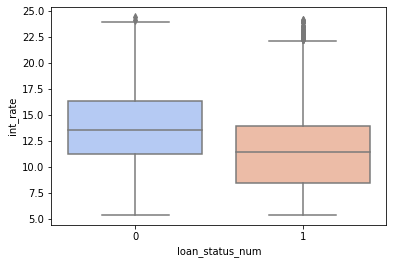

In [19]:
# Box plot showing the relation between the loan default and int_rate, it shows that for loan defaulters (loan_status_num=0)
# the average of int_rate is higher than that for non defaulters (loan_status_num=1)

snp.boxplot(x='loan_status_num',y='int_rate',data=loan,palette='coolwarm')

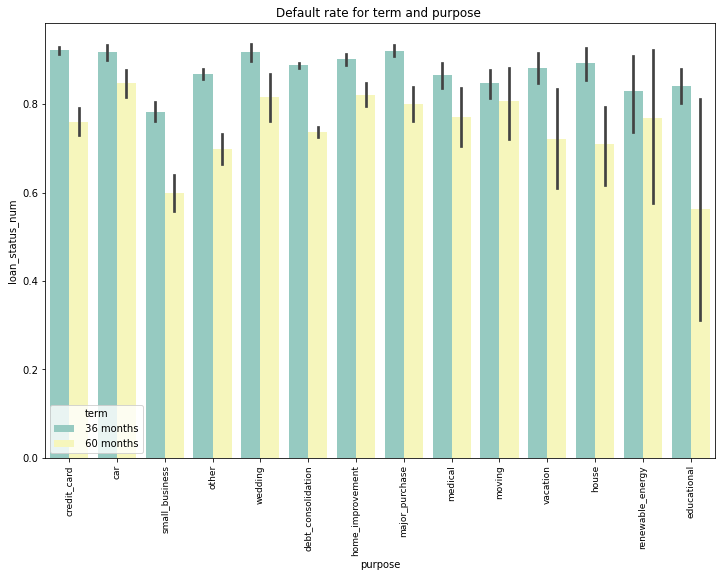

In [20]:
# plotting default rate for purpose and term 

plt.figure(figsize=(12,8))
snp.barplot(x ="purpose",  y ="loan_status_num", hue='term', data = loan,palette='Set3')
plt.title('Default rate for term and purpose ')
plt.xticks(rotation = 90, fontsize = 9)
plt.show()

# Final Analysis

In [21]:
# Converting newdiff dict to series for sorting key:value pairs
newseries=pd.Series(newdiff) # As explained newdiff is the dictionary with all key value pairs returned by plotdefaultrate functioni.e.Columnname and difference between max and min

# sorting the dict newdiff in descending order to get the highest differences at the top - 
# remember higher the difference higher is the influence of the variable
sorteddiff=newseries.sort_values(ascending=False)
sorteddiff

sub_grade              0.45
int_rate_bin           0.31
grade                  0.28
annual_inc_bin         0.18
home_ownership         0.18
purpose                0.17
term                   0.14
funded_amnt_inv_bin    0.11
loan_amnt_bin          0.11
dti_cat_bin            0.04
verification_status    0.04
emp_length             0.03
dtype: float64

```Clearly these are the top 12 factors that are influencing Default rate and we recommend these to the Consumer Finance company to consider for any loan approval / rejection```